<a href="https://colab.research.google.com/github/IreneLedyaeva/CAP-5610/blob/master/HW3/problem_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## t-SNE visualization

### Uploading the model obtained in problem 2

In [1]:
from google.colab import files

uploaded = files.upload()

Saving cats_and_dogs_pretrained.h5 to cats_and_dogs_pretrained.h5


### Downloading the cats vs dogs data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-15 04:10:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  75.1MB/s    in 0.9s    

2019-04-15 04:10:09 (75.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Extracting the data locally in /tmp

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Loading validation images

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

validation_dir = os.path.join(base_dir, 'validation')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
from keras.preprocessing.image import ImageDataGenerator

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Using TensorFlow backend.


Found 1000 images belonging to 2 classes.


### Loading modules

In [0]:
from keras import models

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

### Getting the last convolutional layer

In [7]:
from keras.models import load_model

model = load_model('cats_and_dogs_pretrained.h5')
model.summary()

layer = model.get_layer('dense_1')
layer_output = layer.output

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  """Entry point for launching an IPython kernel.


In [0]:
activations = activation_model.predict_generator(validation_generator, steps=25)

### Visualization of the feature vectors produced by the convnet

In [0]:
def data_scatter(vecs, labels):
  
  num_classes = len(np.unique(labels))
  palette = np.array(sns.color_palette("husl", num_classes))

  f = plt.figure(figsize=(12, 12))
  ax = plt.subplot(aspect='equal')
  sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
  plt.xlim(-25, 25)
  plt.ylim(-25, 25)
  ax.axis('off')
  ax.axis('tight')

  for idx in range(num_classes):
    x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
    txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
    txt.set_path_effects([PathEffects.Stroke(linewidth=6, foreground="w"), PathEffects.Normal()])

### t-SNE 

In [18]:
from sklearn.manifold import TSNE


time_start = time.time()
cats_dogs_tsne = TSNE(random_state=42).fit_transform(activations)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 3.8325717449188232 seconds


### Visualizing t-SNE output 

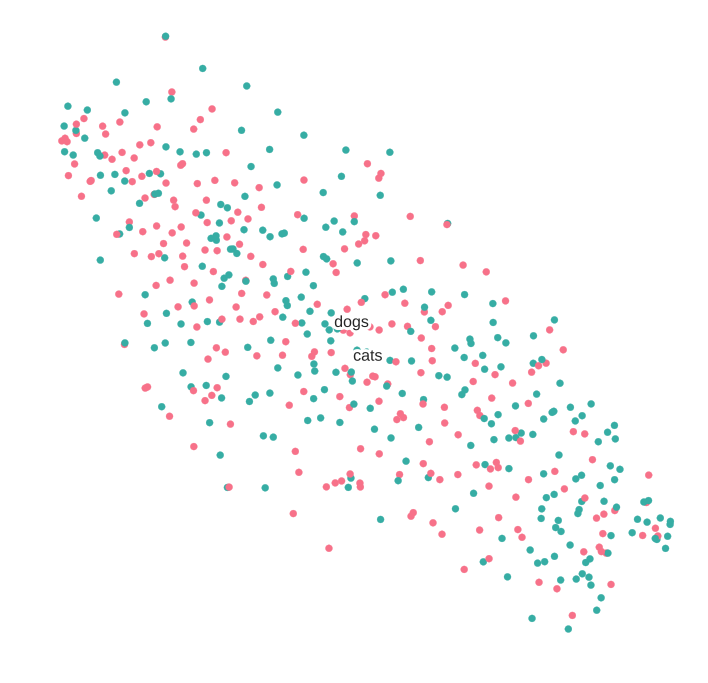

In [63]:
labels = validation_generator.classes
np.random.shuffle(labels)
labels = labels[:500]
class_names = ['dogs', 'cats']
data_scatter(cats_dogs_tsne, labels)